# Low-rank nonnegative tensor approximation via alternating projections and sketching

In [2]:
##
%reload_ext autoreload
%autoreload 2
##

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio

from time import time
import sys #
sys.path.append('./src') #

from truncatedSvd import TruncatedSvd
from experiment import Experiment

/home/azamat/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%%bash
lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   39 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          4
On-line CPU(s) list:             0-3
Vendor ID:                       GenuineIntel
Model name:                      Intel(R) Core(TM) i3-8130U CPU @ 2.20GHz
CPU family:                      6
Model:                           142
Thread(s) per core:              2
Core(s) per socket:              2
Socket(s):                       1
Stepping:                        10
BogoMIPS:                        4416.00
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology cpuid pni pclmulqdq vmx ssse3 fma cx16 pcid sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single 

## 1. Multidimensional Gaussian mixture

In [4]:
t0 = time()

N = 128
N1 = N
N2 = N
N3 = N
A = np.zeros([N1, N2,N3])
cov_mat = np.random.uniform(0, 1, [3,3])
cov_mat = cov_mat @ cov_mat.T
cov_mat = cov_mat / np.linalg.norm(cov_mat)
cov_mat2 = np.random.uniform(0, 1, [3,3])
cov_mat2 = cov_mat2 @ cov_mat2.T
cov_mat2 = cov_mat2 / np.linalg.norm(cov_mat2)

cov_mat3 = np.random.uniform(0, 1, [3,3])
cov_mat3 = cov_mat3 @ cov_mat3.T
cov_mat3 = cov_mat3 / np.linalg.norm(cov_mat3)

h = 4. / N
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            point = np.array([i*h, j*h, k*h])
            A[i,j,k] = np.exp(-point @ cov_mat  @ point) +\
                       np.exp(-point @ cov_mat2 @ point) +\
                       np.exp(-point @ cov_mat3 @ point)
            
print('%d s.' % (time() - t0))

155 s.


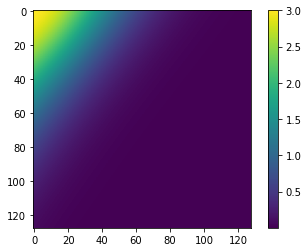

In [9]:
plt.imshow(A[:, :, 0])
_ = plt.colorbar()

In [33]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=1,  k=15))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=0,  k=16))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=10, l=25))
# nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6,  l=11))

nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=1, k=14))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=0, k=14))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=29))
# nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6, l=10))


tuckerRank = (5, 5, 5)
ttRank = (5, 5)
itersNum = 100

ex = Experiment(tensor=A,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList)

In [34]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      0.32026
negative elements (fro)      |     0.000962
negative elements (che)      |     0.000012
negative elements (%)        |   8.69679451
relative error (fro)         | 0.0000515274
relative error (che)         | 0.0002881244
r2_score                     | 0.9999999972
compression                  |       468.11
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      0.33007
negative elements (fro)      |     0.001296
negative elements (che)      |     0.000014
negative elements (%)        |   4.18639183
relative error (fro)         | 0.0000549251
relative error (che)         | 0.0003607857
r2_score                     | 0.9999999968
compression                  |      1025.50
-------------------------------------------


In [35]:
ex.time(itersNum, nttsvd=True, nsthosvd=False)

NTTSVD
------------------------------------
SVD$_r$                 |  42.51 s.
HMT(1,14), Rad          |  10.95 s.
HMT(0,14), Rad          |   8.55 s.
Tropp(7,29), Rad        |   6.10 s.
------------------------------------


In [42]:
ex.time(itersNum, nttsvd=False, nsthosvd=True)

NSTHOSVD
------------------------------------
SVD$_r$                 |  41.16 s.
HMT(1,15), Rad          |  14.06 s.
HMT(0,16), Rad          |  11.91 s.
Tropp(10,25), Rad       |   9.34 s.
------------------------------------


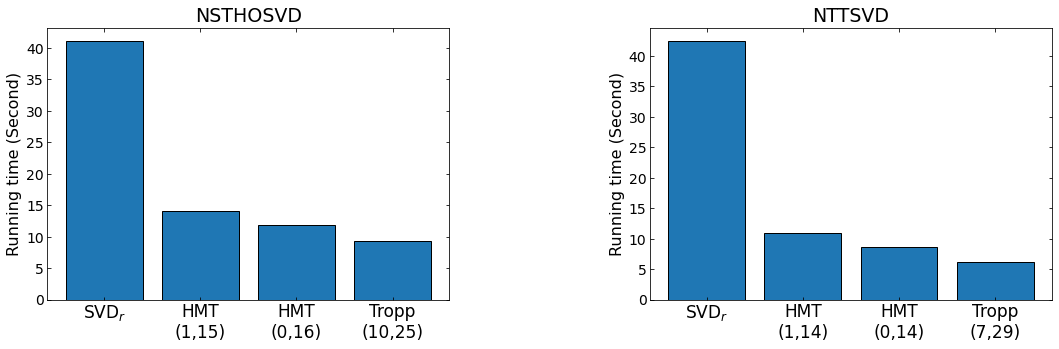

In [43]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=19,
                          ylabelsize=16,
                          xticksize=17,
                          yticksize=14,
                          wspace=0.5,
                          paramsNewLine=True)

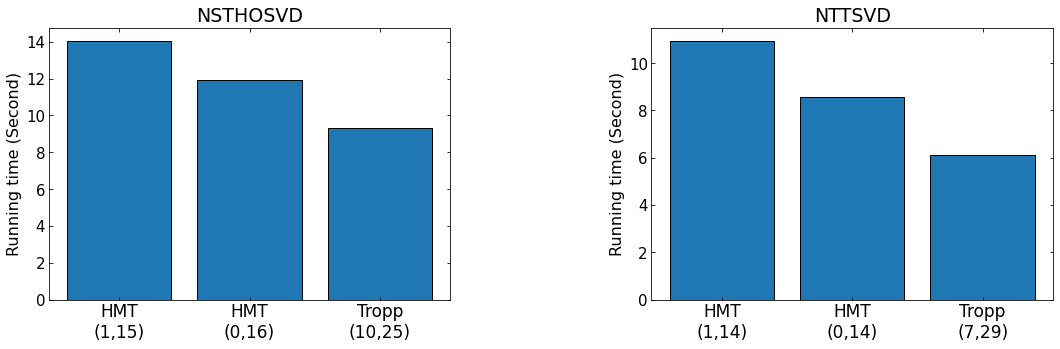

In [44]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=19,
                          ylabelsize=16,
                          xticksize=17,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

In [51]:
ex.run(itersNum=itersNum)

NTTSVD
------------------------------------
SVD$_r$                  |  44.37 s.
HMT(1,14), Rad           |  13.54 s.
HMT(0,14), Rad           |  11.61 s.
Tropp(7,29), Rad         |   9.53 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  |  51.40 s.
HMT(1,15), Rad           |  19.54 s.
HMT(0,16), Rad           |  20.92 s.
Tropp(10,25), Rad        |  15.44 s.
------------------------------------


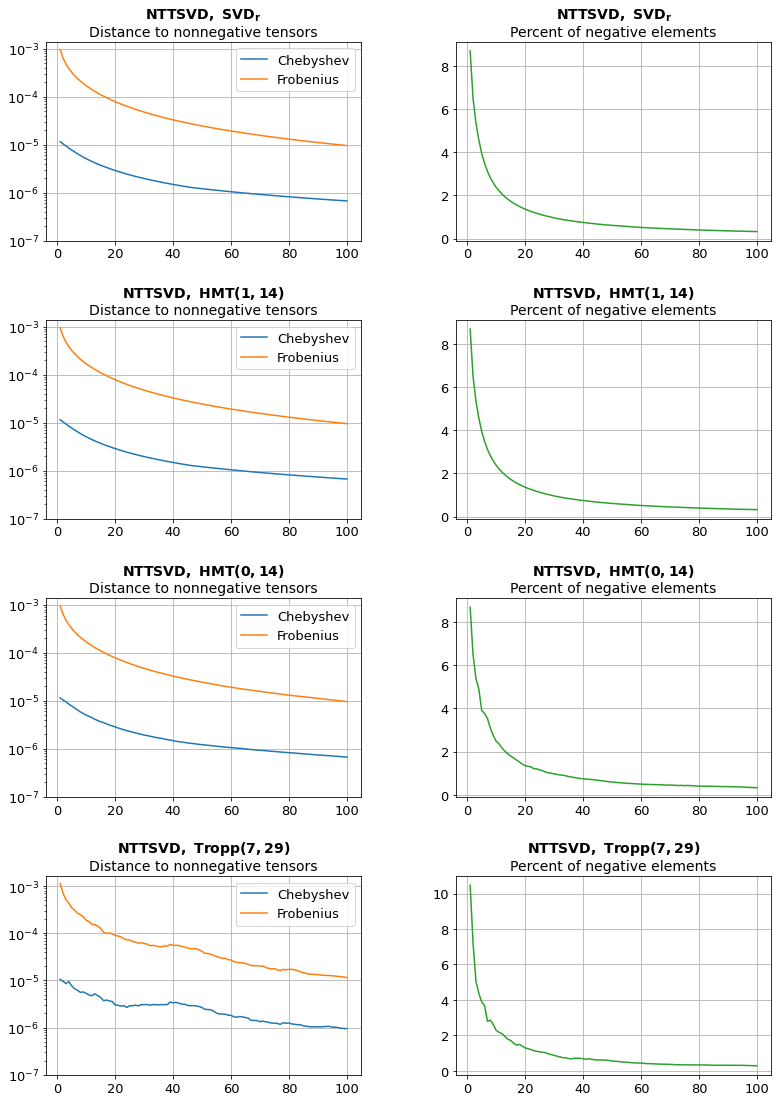

In [52]:
fig, ax = ex.plotConvergence2(nsthosvd=False,
                              figsize=(13, 19),
                              yticks=[10**(-x) for x in range(3, 8)],
                              hspace=0.4, wspace=0.3,
                              titlesize=14,
                              ticksize=13,
                              legendsize=13,
                              legendloc='upper right')

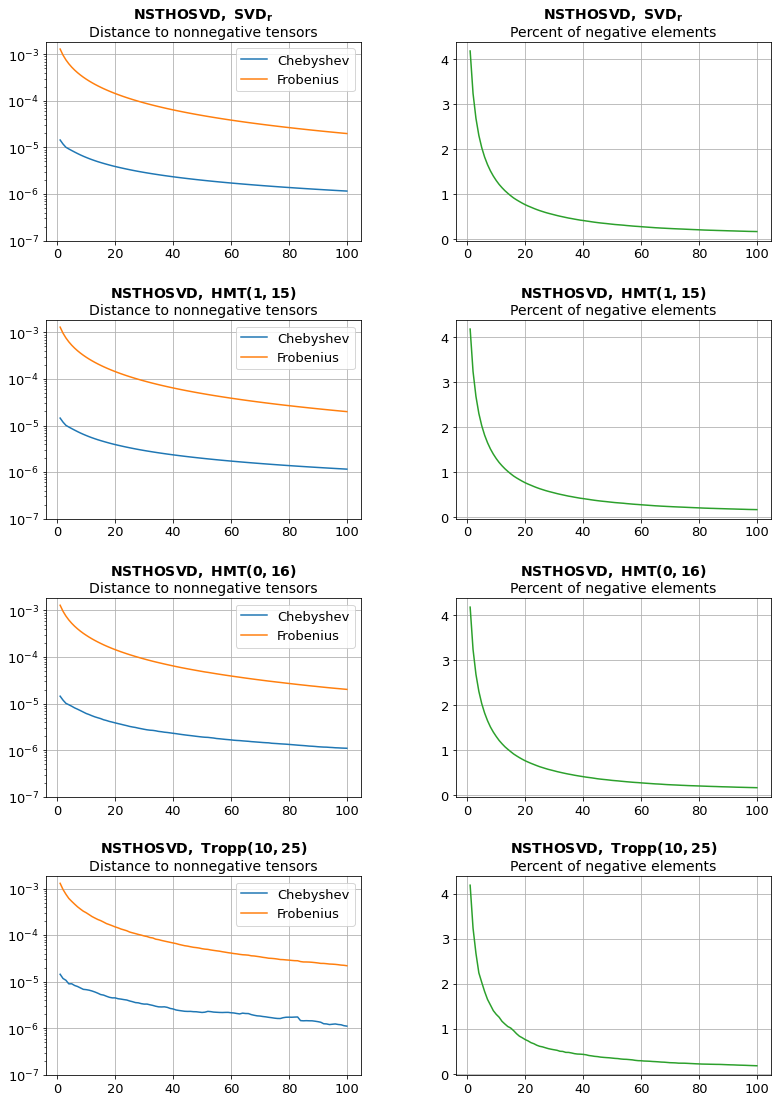

In [53]:
fig, ax = ex.plotConvergence2(nttsvd=False,
                              figsize=(13, 19),
                              yticks=[10**(-x) for x in range(3, 8)],
                              hspace=0.4, wspace=0.3,
                              titlesize=14,
                              ticksize=13,
                              legendsize=13,
                              legendloc='upper right')

In [49]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | r2_score |
------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000051895558822776 | 0.000292731556424582 | 1.000000 |
| HMT(1,14), Rad           | 0.000051895558822762 | 0.000292731556075528 | 1.000000 |
| HMT(0,14), Rad           | 0.000051899837212349 | 0.000292658581749539 | 1.000000 |
| Tropp(7,29), Rad         | 0.000054833841601777 | 0.000258370709079081 | 1.000000 |
------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | r2_score |
------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000055753614477727 | 0.000368382208918957 | 1.000000 |
| HMT(1,15), Rad           | 0.000055753614477828 | 0.000368382208121668 | 1.000000 |
| HMT(0,16), Rad           | 0.000055756535796814 | 0.000

In [50]:
ex.printNegativeElements()

| NTTSVD                   | negative elements (%) |
----------------------------------------------------
| SVD$_r$                  |             0.3240108 |
| HMT(1,14), Rad           |             0.3240108 |
| HMT(0,14), Rad           |             0.3128052 |
| Tropp(7,29), Rad         |             0.2953529 |
----------------------------------------------------
| NSTHOSVD                 | negative elements (%) |
----------------------------------------------------
| SVD$_r$                  |             0.1645565 |
| HMT(1,15), Rad           |             0.1645565 |
| HMT(0,16), Rad           |             0.1642227 |
| Tropp(10,25), Rad        |             0.1596451 |
----------------------------------------------------
